# 1、卷积神经网络（LeNet）

LeNet(LeNet-5) 有两个部分组成：卷积编码器和全连接层密集块

In [5]:
import torch 
from torch import nn
from d2l import torch as d2l

class Reshape(torch.nn.Module):
    def forward(self,x):
        return x.view(-1,1,28,28)     #通过reshape把数据放成批量数不变，通道数变成1,28*28    

net = torch.nn.Sequential(
    Reshape(),                   #原始图片输入为32*32，reshape成28*28
    nn.Conv2d(1,6,kernel_size=5,padding=2),     #然后再边缘pad了2列  ; 28-5+1+2*2 =28  [-1,6,28,28]    
    nn.Sigmoid(),            #为了得到非线性
    nn.AvgPool2d(kernel_size=2,stride=2), #2*2 不重叠取平均池化    (28-2+1+2)/2 =14      [-1,6,14,14]
    nn.Conv2d(6,16,kernel_size=5),  #输出变多了,   (14-5+1)=10                  [-1,16,10,10]
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2),    #(10-2+1+2)/2=5             [-1,16,5,5]
    nn.Flatten(),              #上一步输出为4d张量，然后拉成1维张量,批量保持住，后面拉平  [-1,16*5*5]
    nn.Linear(16*5*5,120),
    nn.Sigmoid(),
    nn.Linear(120,84),
    nn.Linear(84,10)
    
    
)

In [7]:
X = torch.rand(size=(1,1,28,28),dtype = torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'outputshape:\t',X.shape)

Reshape outputshape:	 torch.Size([1, 1, 28, 28])
Conv2d outputshape:	 torch.Size([1, 6, 28, 28])
Sigmoid outputshape:	 torch.Size([1, 6, 28, 28])
AvgPool2d outputshape:	 torch.Size([1, 6, 14, 14])
Conv2d outputshape:	 torch.Size([1, 16, 10, 10])
Sigmoid outputshape:	 torch.Size([1, 16, 10, 10])
AvgPool2d outputshape:	 torch.Size([1, 16, 5, 5])
Flatten outputshape:	 torch.Size([1, 400])
Linear outputshape:	 torch.Size([1, 120])
Sigmoid outputshape:	 torch.Size([1, 120])
Linear outputshape:	 torch.Size([1, 84])
Linear outputshape:	 torch.Size([1, 10])


LeNet在Fash-Mnist数据集上的表现

In [9]:
batch_size = 256
train_iter,test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

100.0%

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw


111.0%

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw


100.0%

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw


159.1%

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw
Processing...
Done!


/home/snnu/miniconda3/envs/torch18/lib/python3.8/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [13]:
train_iter

In [14]:
test_iter

对evaluate_accuracy函数进行轻微的修改

In [10]:
def evaluate_accuracy_gpu(net,data_iter,device=None):
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net,torch.nn.Module):
        net.eval()                                    #进入评估模式
        if not device:                               #将网络层中的第一个参数的device拿出来
            device = next(iter(net.parameters())).device
    metric = d2l.Accumulator(2)                      #做一个累加器
    for X,y in data_iter:                            
        if isinstance(X,list):                       #如果数据是list就每个挪一下
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)                          #如果是tensor就挪一次
        y = y.to(device)                              #把标签也放过去
        metric.add(d2l.accuracy(net(X),y),y.numel())   #计算  accuracy，计算y的个数
        return metric[0]/metric[1]

为了使用GPU，我们还需要一点小改动

In [19]:
def train_ch6(net,train_iter,test_iter,num_epochs,lr,device):
    """使用GPU进行训练"""
    def init_weights(m):
        if type(m) ==nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)             #根据输入输出大小，评估模型方差，保证模型一开始不要炸了
    net.apply(init_weights)                            #对net中每一个parameter初始化权重
    print("training on ", device)
    net.to(device)                                    #参数挪到device
    optimizer = torch.optim.SGD(net.parameters(),lr=lr)  
    loss = nn.CrossEntropyLoss()                      #多类分类问题
    animator = d2l.Animator(xlabel = 'epoch',xlim=[1,num_epochs],             #动画效果
                            legend=['train loss','train acc','test acc'])
    timer,num_batches = d2l.Timer() , len(train_iter)
    for epoch in range(num_epochs):               #对每次输入做迭代   
        metric = d2l.Accumulator(3)
        net.train()
        for i ,(X,y) in enumerate(train_iter):      #每次迭代中取一个batch
            timer.start()
            optimizer.zero_grad()                    #梯度设零
            X,y = X.to(device),y.to(device)         #挪到gpu
            y_hat = net(X)                          #X丢进网络,前向操作，
            l = loss(y_hat,y)                       #计算损失
            l.backward()                             #计算梯度
            optimizer.step()                        #优化权重参数
            metric.add(l*X.shape[0],d2l.accuracy(y_hat,y),X.shape[0])  #存储绘图参数值
            timer.stop()
            train_l = metric[0]/metric[2]
            train_acc = metric[1] / metric[2]
            if (i+1) %(num_batches//5) == 0 or i == num_epochs-1:
                animator.add(epoch+(i+1)/num_batches,
                            (train_l,train_acc,None))
        test_acc = evaluate_accuracy_gpu(net,test_iter)
        animator.add(epoch+1 ,(None,None,test_acc))
    print(f'loss {train_l:.3f}, trian acc {train_acc:.3f} , test acc {test_acc:.3f}')
    print(f'{metric[2]*num_epochs/timer.sum():.1f} ',f'expamples/sec on {str(device)}')
            
            

训练和评估LeNet-5模型

loss 0.537, trian acc 0.792 , test acc 0.754
68618.6  on cuda:0


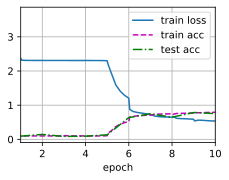

In [21]:
lr , num_epochs = 0.9 ,10
train_ch6(net,train_iter,test_iter,num_epochs,lr,d2l.try_gpu())